# About

A script to show statistical analysis of the connectome data.
The goal of these stats to provide some insight as to how the data
is distributed, and uncover correlations.

# Libaries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import spatial

import torch

# Custom libraries
import libs.funLib as myFn

# Check GPU

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name = torch.cuda.get_device_name(0)
print('Using {} device'.format(device))
print('Device name: {}'.format(device_name))
print('Number of cores: {}'.format(torch.cuda.device_count()))

Using cuda device
Device name: NVIDIA GeForce GTX 1070 Ti
Number of cores: 1


# Directories

In [ ]:
dirData = os.path.join(os.getcwd(), 'data', 'connectome', 'SickKidsConnectomes')
dirRegions = os.path.join(dirData, 'HCP-MMP1_UniqueRegionList.csv')

# Functional Connectome data:
dirFunCon = os.path.join(dirData, 'WholeBrain_FunctionalConnectomesMat')
listDirFuns = os.listdir(dirFunCon)

# Structural Connectome data:
dirStruct = os.path.join(dirData, 'StructuralConnectomes')
dirNames = os.path.join(dirData, 'StructuralConnectomes_ParticipantGroups.xlsx')
listFilesStruct = os.listdir(dirStruct)
listFilesStruct.sort()

# Import data

## Spatial coordinates and region names

In [ ]:
regionTable = pd.read_csv(dirRegions)
regionNames = regionTable['regionLongName'].values
X = regionTable['x-cog'].values
Y = regionTable['y-cog'].values
Z = regionTable['z-cog'].values

coords = np.column_stack((X,Y,Z))
vols = regionTable['volmm'] # Volume of each region in mm^3
rads = vols / 10
N = regionNames.size

## Structural data

In [ ]:
# Labels for structural connectomes (Classes: healthy=0, surgery=1, radiation=2)
labeldfs = pd.read_excel(dirNames, sheet_name=None)
labelsRaw = labeldfs['Sheet1'].values # Sheet name (bottom left of Excel file) is the key.
labelsSub = [x[0] for x in labelsRaw]

# Import each csv and create tensor list:
listStructs = []
listLabels = []

for i in range(len(listFilesStruct)):
    # Structure:
    fileName = listFilesStruct[i]
    dirFile = os.path.join(dirStruct, fileName)
    arrayPD = pd.read_csv(dirFile, header=None)

    # Concatenate:
    arrayStruct = arrayPD.values[:N, :N]
    listStructs.append(arrayStruct)

    nameSub = fileName[:4]
    ind = labelsSub.index(nameSub)

    status = labelsRaw[ind][2]
    if status == 'HealthyControl':
        listLabels.append(0)
    elif status == 'SURGERY_ONLY':
        listLabels.append(1)
    elif status == 'RADIATION':
        listLabels.append(2)
    else:
        listLabels.append(3)

arrStructs = np.array(listStructs)
arrLabels = np.array(listLabels)

# Categorize by label

In [ ]:
# Cortex type
cortexList = regionTable['cortex'].values
cortexNames, cortexInds = myFn.obtainCollection(cortexList)

# Lobe type 
lobeList = regionTable['Lobe'].values
lobeNames, lobeInds = myFn.obtainCollection(lobeList)

## Display label nodes

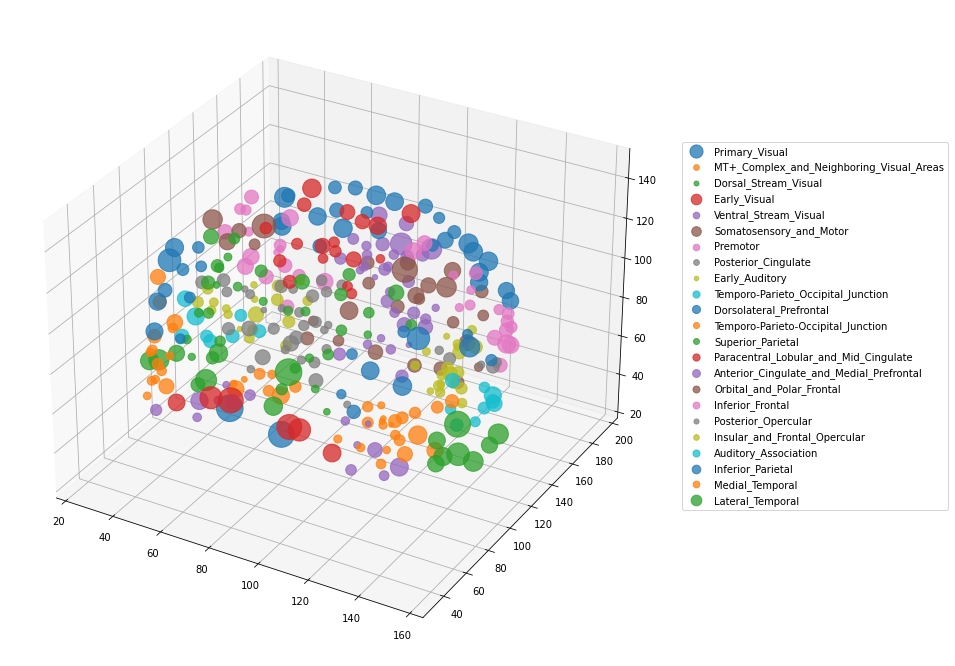

In [ ]:
# Colour code the nodes in accordance to each collection
fig = plt.figure(figsize=(16,12))

ax = fig.add_subplot(projection='3d')

# Plot different colours based on labels:
collectionNames = cortexNames # lobeNames
collectionInds = cortexInds # lobeInds

for k in range(len(collectionNames)):
    inds = collectionInds[k]
    ax.scatter3D(X[inds], Y[inds], Z[inds], s=rads[inds], alpha=0.75)
    
ax.legend(collectionNames, 
    loc='upper right', 
    markerscale=0.5, 
    bbox_to_anchor=(1.45,0.8))

# Statistical plots

The goal here is to loosely determine the distribution of the DTI values. We suspect that it approximates the alpha distribution as a ratio with distance.

## Structural adjacency plots

We provide the following plots for each class of patients:
 - CDF of patients with respect to number of existing connections.
 - Histogram showing number of avg. connections over all patients across all dist. bins
 - Histogram showing distribution of connectivity fraction of patients.

### Configure arrays

In [ ]:
# Euclidean distance matrix
dists = spatial.distance.cdist(coords, coords)
eps = 1e-06 # Prevent division by zero entries

# Other parameters
numPatients = arrStructs.shape[0]

# Set up arrays: H = Healthy, SO = Surgery only, R = Radiation
numPatientsH = np.count_nonzero(arrLabels == 0)
numPatientsSO = np.count_nonzero(arrLabels == 1)
numPatientsR = np.count_nonzero(arrLabels == 2)

numConnsH = np.zeros((N,N))
numConnsSO = np.zeros((N,N))
numConnsR = np.zeros((N,N))

for k in range(numPatients):
    arrStruct = arrStructs[k,:,:]
    arrAdj = (arrStruct > 0).astype('int64')
    statusPatient = arrLabels[k]
    if statusPatient == 0:
        numConnsH += arrAdj
    elif statusPatient == 1:
        numConnsSO += arrAdj
    elif statusPatient == 2:
        numConnsR += arrAdj

dist1d = np.reshape(dists, -1)
numConnsH1d = np.reshape(numConnsH, -1) / numPatientsH
numConnsSO1d = np.reshape(numConnsSO, -1) / numPatientsSO
numConnsR1d = np.reshape(numConnsR, -1) / numPatientsR

# Histogram arrays for connectivity fraction
histH = np.histogram(numConnsH1d, bins=10)
histSO = np.histogram(numConnsSO1d, bins=10)
histR = np.histogram(numConnsR1d, bins=10)

# Histogram arrays for avg. connections over distances
histdistH = np.histogram(dist1d, bins=20, range=(0,200), weights=numConnsH1d)
histdistSO = np.histogram(dist1d, bins=20, range=(0,200), weights=numConnsSO1d)
histdistR = np.histogram(dist1d, bins=20, range=(0,200), weights=numConnsR1d)

### Histogram of avg. connections over distances

Can be used to define a conditional probability dist | conn = 1. Using Baye's theorem,
 we can obtain the conditional probability conn = 1 | dist to sample each edge.

Text(0, 0.5, 'Number of connections (DTI > 0)')

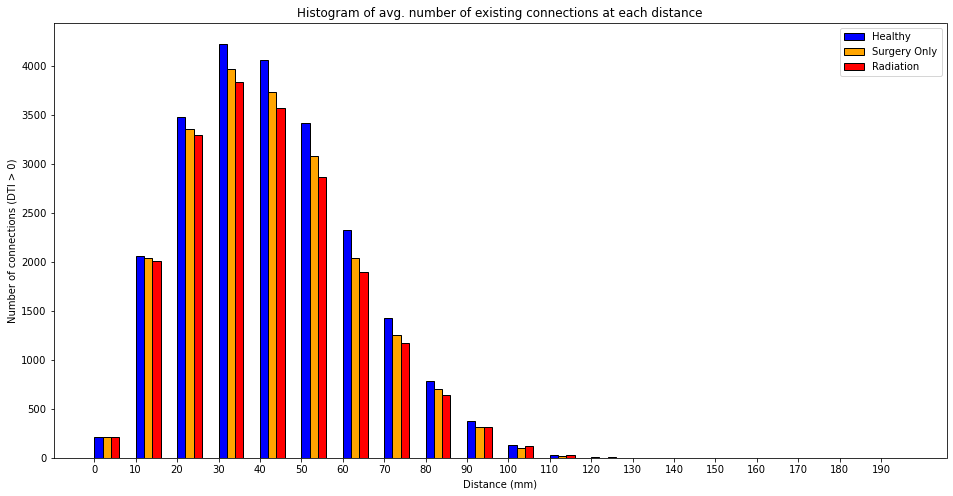

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,8))

binDistarr = histdistH[1][:-1]

ax.bar(binDistarr, histdistH[0],
    width=2.0,
    align='edge',
    color='blue',
    edgecolor='black')

ax.bar(binDistarr+2.0, histdistSO[0],
    width=2.0,
    align='edge',
    color='orange',
    edgecolor='black')

ax.bar(binDistarr+4.0, histdistR[0],
    width=2.0,
    align='edge',
    color='red',
    edgecolor='black')

ax.set_xticks(binDistarr)
ax.set_xticklabels(np.floor(binDistarr).astype('int64'))

ax.set_title('Histogram of avg. number of existing connections at each distance')
ax.legend(['Healthy', 'Surgery Only', 'Radiation'], loc='upper right')
ax.set_xlabel('Distance (mm)')
ax.set_ylabel('Number of connections (DTI > 0)')

### Histogram of patient count

Text(0.5, 0, 'isConnected patient count percentage')

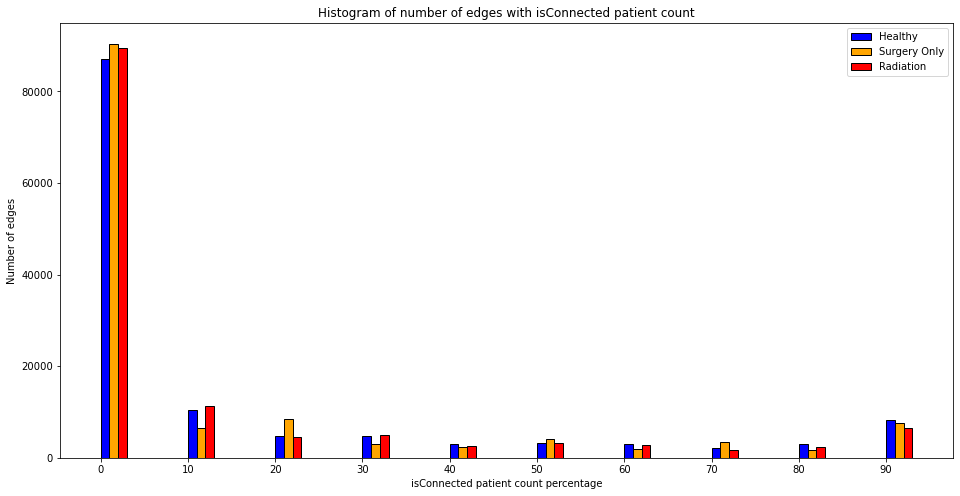

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,8))

binarr = histH[1][:-1]

ax.bar(binarr, histH[0], 
    width=0.01, 
    align='edge', 
    color='blue', 
    edgecolor='black')

ax.bar(binarr+0.01, histSO[0],
    width=0.01,
    align='edge',
    color='orange',
    edgecolor='black')

ax.bar(binarr+0.02, histR[0],
    width=0.01,
    align='edge',
    color='red',
    edgecolor='black')

ax.set_title('Histogram of number of edges with isConnected patient count')
ax.set_xticks(binarr)
ax.set_xticklabels(np.floor(100*binarr).astype('int64'))

ax.legend(['Healthy', 'Surgery Only', 'Radiation'], loc='upper right')
ax.set_ylabel('Number of edges')
ax.set_xlabel('isConnected patient count percentage')

## Distribution plots

Here, we assess the distribution of the DTI values, and whether there is
a correlation between distance and DTI. We plot the following:
- Average DTI vs. distance for each edge across H, SO, R patients
- K-S p-values for each edge across H, SO, R patients

### Configure arrays

In [ ]:
indsH = np.where(arrLabels == 0)
indsSO = np.where(arrLabels == 1)
indsR = np.where(arrLabels == 2)

# Separate patient data to individual 3d structures
arrStructsH = arrStructs[indsH[0],:,:]
arrStructsSO = arrStructs[indsSO[0],:,:]
arrStructsR = arrStructs[indsR[0],:,:]

# Average across each edge:
avgH = np.mean(arrStructsH, axis=0)
avgSO = np.mean(arrStructsSO, axis=0)
avgR = np.mean(arrStructsR, axis=0)

avgH1d = np.reshape(avgH, -1)
avgSO1d = np.reshape(avgSO, -1)
avgR1d = np.reshape(avgR, -1)

distPosH = dist1d[avgH1d > 0]
distPosSO = dist1d[avgSO1d > 0]
distPosR = dist1d[avgR1d > 0]



### Scatter plot

Text(0.5, 0, 'Edge distance (mm)')

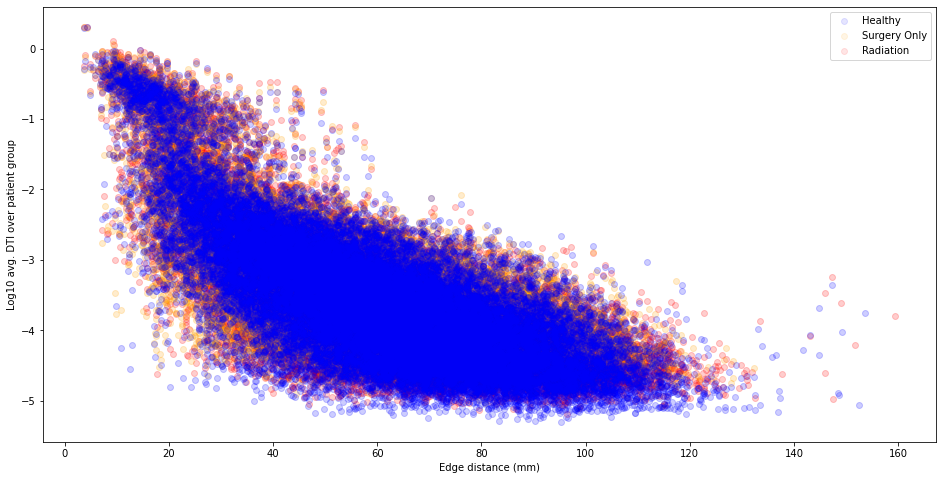

In [ ]:
fig, ax = plt.subplots(1, figsize=(16,8))

ax.scatter(distPosH, np.log10(avgH1d[avgH1d > 0]), color='blue', alpha=0.1, zorder=2)
ax.scatter(distPosSO, np.log10(avgSO1d[avgSO1d > 0]), color='orange', alpha=0.1, zorder=1)
ax.scatter(distPosR, np.log10(avgR1d[avgR1d > 0]), color='red', alpha=0.1, zorder=0)

ax.legend(['Healthy', 'Surgery Only', 'Radiation'], loc='upper right')
ax.set_ylabel('Log10 avg. DTI over patient group')
ax.set_xlabel('Edge distance (mm)')

## K-S Statistics

We compare the distribution of the DTI readings with various pdfs using K-S testing.
We partition the readings across types of patients and edges. Note this is independent of the above graph. We are testing the distribution of the DTI values per edge or region.

For a list of all scipy.stats continuous distributions, see https://docs.scipy.org/doc/scipy/reference/stats.html#module-scipy.stats

### Configure arrays

In [ ]:
# Partition arrays based on edge, region, with patient status
indsEdges = np.arange(N)
cdfexp = 'expon'
dictKS, dictP = myFn.getKsStatistics(arrStructsH, indsEdges, cdfexp)

ValueError: Cross index must be 1 dimensional

In [ ]:
randX = np.random.rand(2,4,5)
s = [0,1]
t = [2,3,4]
# andX[np.ix_(randX.shape[0], s, t)]
XX = randX[np.ix_(np.arange(randX.shape[0]), s, t)]
# np.ix_(np.arange(randX.shape[0]), s, t)
# np.arange(randX.shape[0])
XXX = np.reshape(XX, -1)

In [ ]:
# Indices where there are >0% and <100% connections:
indsPartialConns = np.where((arrNumConns > 0) * (arrNumConns < numPatients))
# Plot random histograms:
nrows = 5
ncols = 5
numPartialConns = indsPartialConns[0].size
indsPlot = np.random.choice(numPartialConns, size=nrows*ncols) # Sample from indices with partial connections

fig, ax = plt.subplots(nrows,ncols, figsize=(16,12))
yarr = np.arange(numPatients) / numPatients
n = 0

for k in range(nrows):
    for l in range(ncols):
        indP = indsPlot[n] # Sampled index to plot
        ind_i = indsPartialConns[0][indP]
        ind_j = indsPartialConns[1][indP]
        n += 1
        xarr = cdfDict[(ind_i, ind_j)]
        
        dist_ij = dists[ind_i, ind_j]
        numConn = arrNumConns[ind_i, ind_j]
        # Remove all zeroes in xarr of cdf:
        indNon0 = np.min(np.where(xarr > 0))
        ax[k,l].plot(xarr[indNon0:], yarr[indNon0:])
        ax[k,l].set_title(f'Dist = %.2f, Conns = %d' % (dist_ij, numConn))
        ax[k,l].set_xticks([])

In [ ]:
# Obtain coordinates with distance and healthy structure:
arrDistsAll = np.array([])
arrDTIAll = np.array([])

indsHealthy = np.where(arrLabels == 0)[0]
arrDist1d = np.reshape(dists, -1)
indD = np.where(arrDist1d > 0)[0]

fig, ax = plt.subplots(1, figsize=(16,12))
ax.set_title('DTI value vs. eucl. dist')

print(indsHealthy.shape)
for i in range(len(indsHealthy)):
    ind = indsHealthy[i]
    arrStruct = arrStructs[ind]
    arrStruct1d = np.reshape(arrStruct, -1)
    indS = np.where(arrStruct1d > 0)[0]
    indNon0 = np.intersect1d(indD, indS)

    ax.scatter(arrDist1d[indNon0], arrStruct1d[indNon0])



In [ ]:
# Obtain indices i,j where there are connections 0% and 100% of the time
# Randomly sample from the indices where connections exist partially for each patient, and do a two-part sampling (one for connection, the other for strength)
# There appears to be a loose correlation between cdf steepness (of a gamma distribution) and the distance?
# Looks for other factors, such as clustering.
# Perhaps the number of neighbouring connections as well? Volume of the region as well.
# Mimic the paper for determining connections
# Use the KS-test with estimated parameters for various distributions.
# Samples are connections with a large number of non-zero values
# Determine percentage of existing connections for healthy + non-healthy
